## Information 

Let Z: (perturbed) pH, X: Distribution of Allelic Variants, Y: Function

Function is `collapsed' into initial slope and final value. 

We expect X at T0 to be highly correlated with the native pH. 

X at the moment can be computed as an average between the allelic abundances at T0 and T9. 

We expect Z to influence both and and Y, and X to influence only Y. We are interested in when X or Z is `closer' to Y, in an information sense. 

The purpose of this notebook is to try and think somewhat more clearly about the subject.



First, we observe the data for X and Y across native and perturbed pHs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functions import get_filepath, find_clustered_orfs, find_orfs, find_orfs_from_cluster, find_cluster_from_orf
from functions import samples_from_soils, perturbed_pHs, native_pH, enriched_native_pH, perturbed_pH_sample, plot
from functions import information_1D, information_1D_2, information_2D, pairwise_cmi_analysis, get_info, get_info_control


soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

native = np.zeros(len(soils))
for i, soil in enumerate(soils):
    native[i] = native_pH(soil)


In [ ]:
import os

os.chdir('/gpfs/projects/p32818/metagenomic_data')

os.getcwd()

import importlib
import functions
importlib.reload(functions)

To speak about allelic abundances, we have to pick a grouping. I am chosing the PCA on row - normalized data help with this. 

/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_51871/796361005.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True)


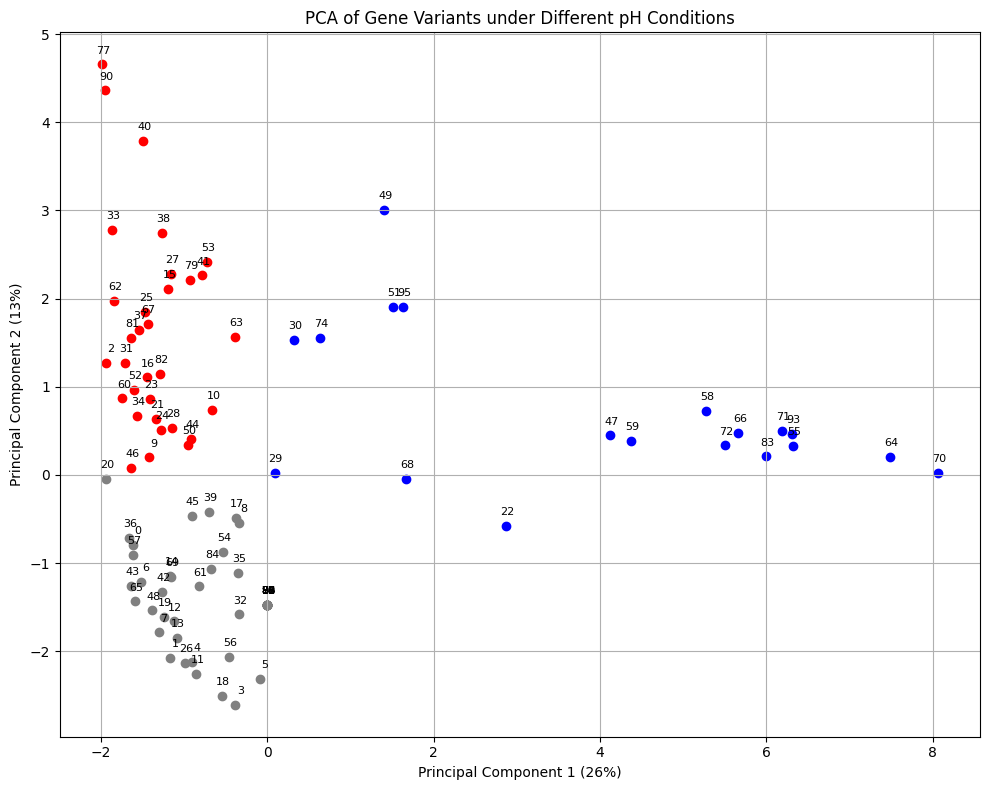

group 1 [22, 29, 30, 47, 49, 51, 55, 58, 59, 64, 66, 68, 70, 71, 72, 74, 83, 93, 95]
group 2 [2, 9, 10, 15, 16, 21, 23, 24, 25, 27, 28, 31, 33, 34, 37, 38, 40, 41, 44, 46, 50, 52, 53, 60, 62, 63, 67, 77, 79, 81, 82, 90]
group 3 [0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 19, 20, 26, 32, 35, 36, 39, 42, 43, 45, 48, 54, 56, 57, 61, 65, 69, 73, 75, 76, 78, 80, 84, 85, 86, 87, 88, 89, 91, 92, 94, 96]


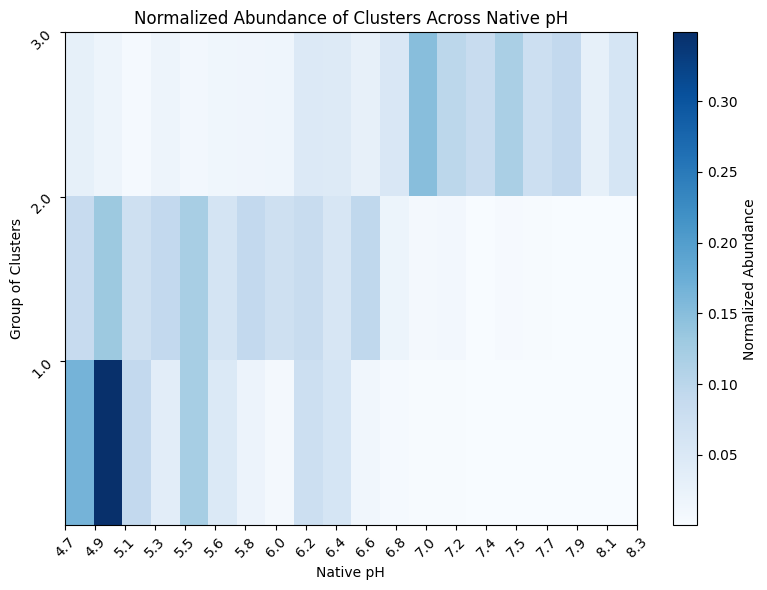

In [4]:


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
clustered_data = clustered_data.values 
normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True)

data = np.nan_to_num(normalized_data)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

group1 = [] #the group of variants with a positive first compenent
group2 = [] #the group of variants with a negative first component, positive second componenet
group3 = [] #the group of variants with a negative first component, negative second componenet

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if principal_components[i, 0] > 0:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='blue')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group1.append(i)
    elif principal_components[i, 1] > 0:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='red')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group2.append(i)
    else:
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='grey')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
        group3.append(i)


plt.xlabel('Principal Component 1 (26%)')
plt.ylabel('Principal Component 2 (13%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()

print('group 1', group1)
print('group 2', group2)
print('group 3', group3)

cluster_IDs = pd.read_csv('out/cluster_ids.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nar.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values


grouped_data = np.zeros((3, 20))

for i, datum in enumerate(clustered_data):
    if i in group1:
        grouped_data[0] += datum
    elif i in group2: 
        grouped_data[1] += datum
    else:
        grouped_data[2] += datum
        
normalized_data = grouped_data / grouped_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)
y = np.linspace(1,3,3)


plt.figure(figsize=(8, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Group of Clusters')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(y[0], y[-1], len(y)), labels=[f"{val:.1f}" for val in y], rotation=45)

plt.tight_layout()
plt.show()

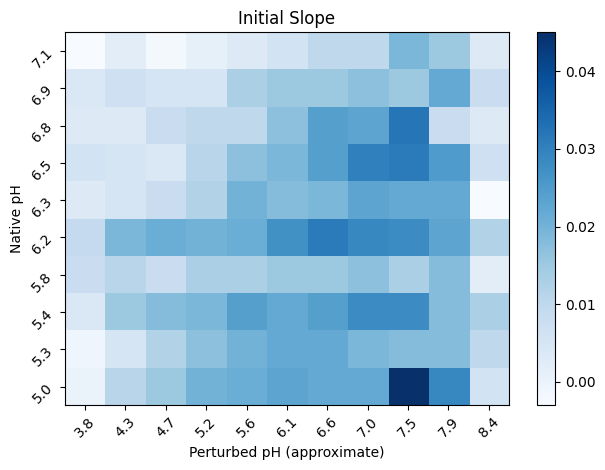

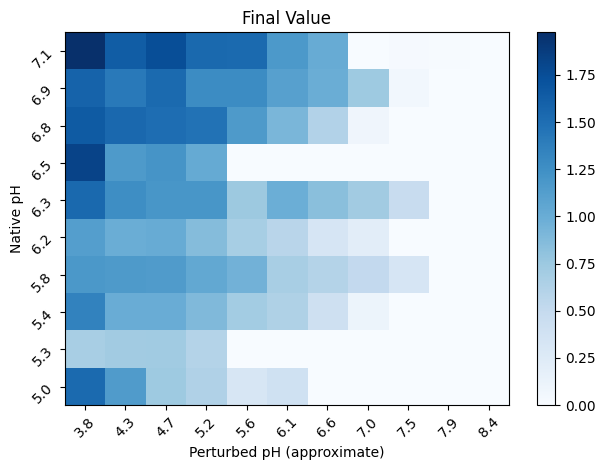

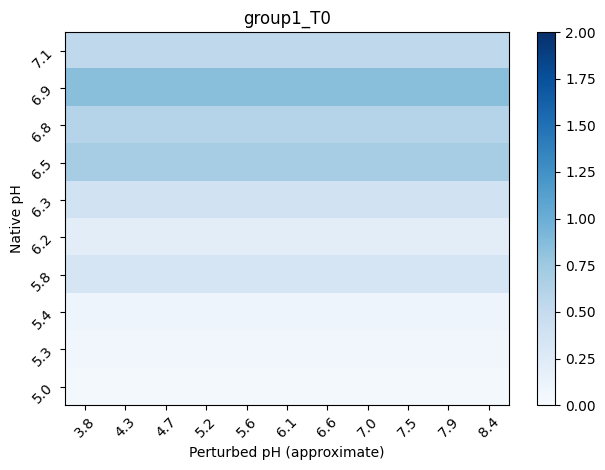

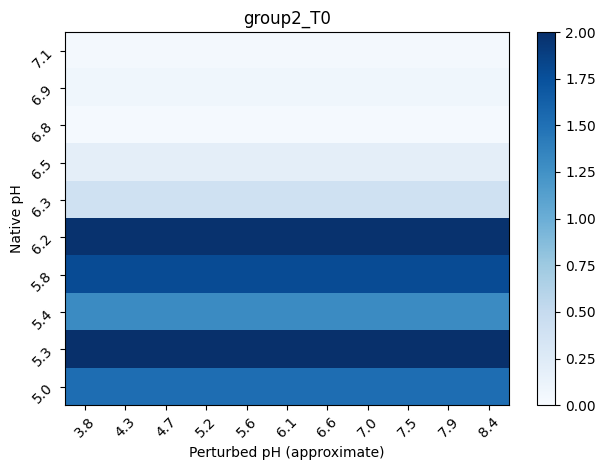

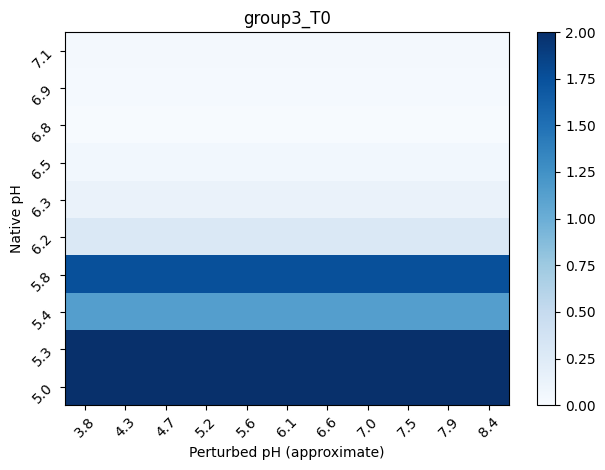

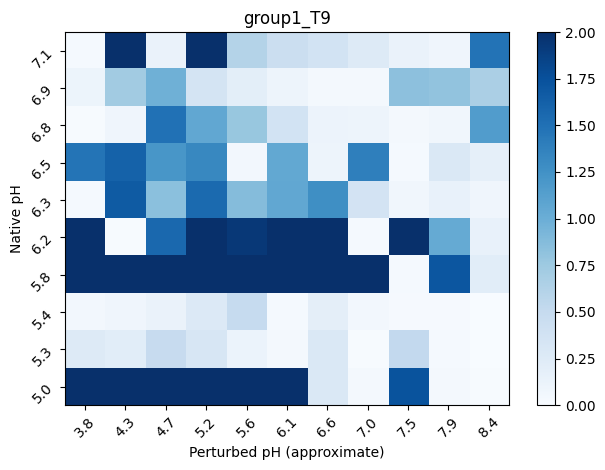

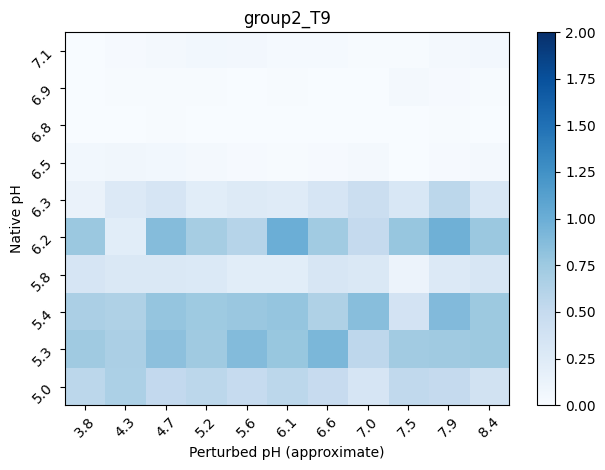

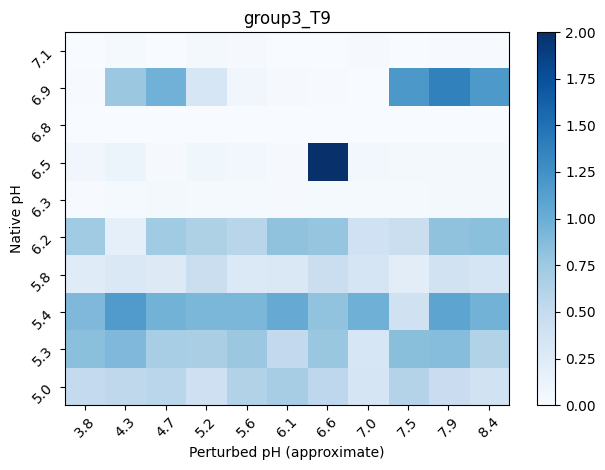

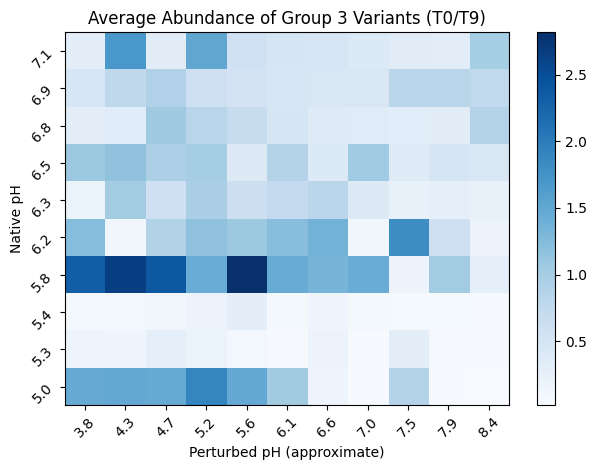

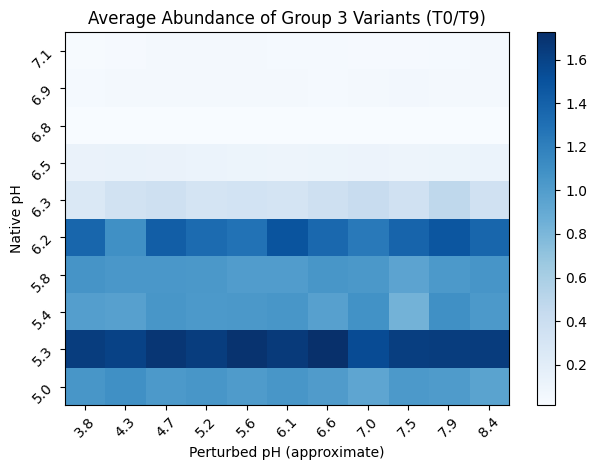

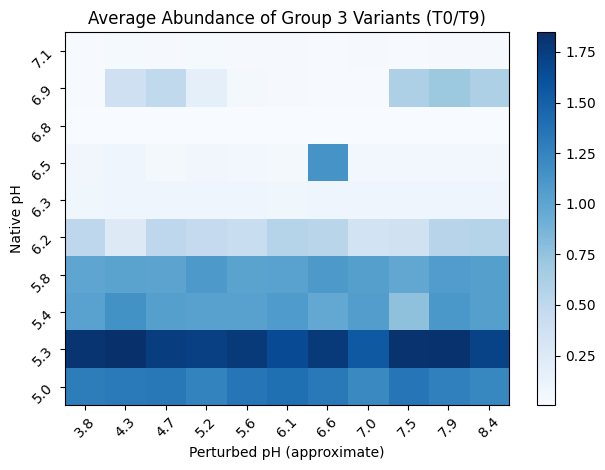

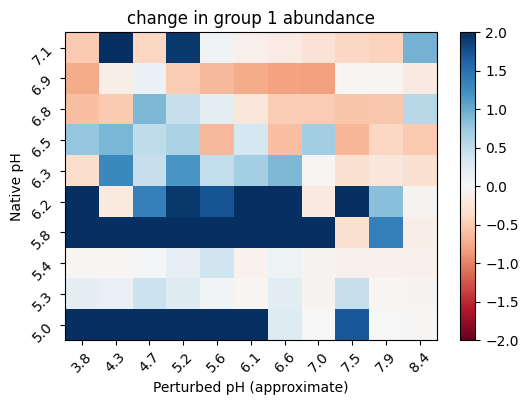

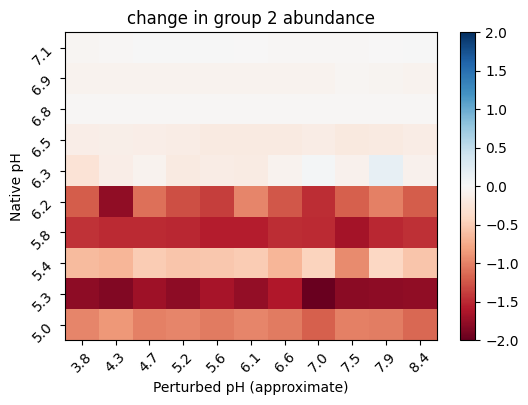

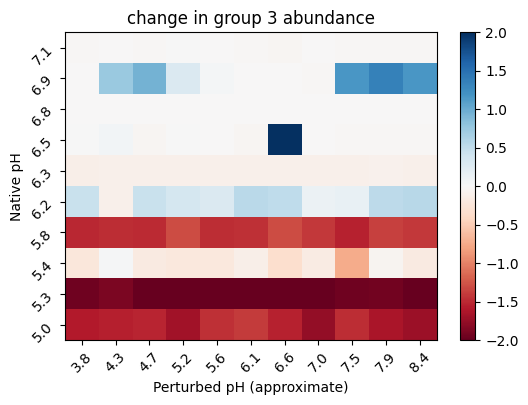

In [5]:
data_slope = pd.read_csv('out/data_slope.tsv', sep='\t', header=None)
data_slope = data_slope.values
data_final = pd.read_csv('out/data_final.tsv', sep='\t', header=None)
data_final = data_final.values

plot(data_slope, 'Initial Slope')
plot(data_final, 'Final Value')


group1_T0 = pd.read_csv('out/group1_T0.tsv', sep='\t', header = None)
group1_T0 = group1_T0.values
group2_T0 = pd.read_csv('out/group2_T0.tsv', sep='\t', header = None)
group2_T0 = group2_T0.values
group3_T0 = pd.read_csv('out/group3_T0.tsv', sep='\t', header = None)
group3_T0 = group3_T0.values

group1_T9 = pd.read_csv('out/group1_T9.tsv', sep='\t', header = None)
group1_T9 = group1_T9.values
group2_T9 = pd.read_csv('out/group2_T9.tsv', sep='\t', header = None)
group2_T9 = group2_T9.values
group3_T9 = pd.read_csv('out/group3_T9.tsv', sep='\t', header = None)
group3_T9 = group3_T9.values

group1_avg = np.average([group1_T0, group1_T9], axis=0)
group2_avg = np.average([group2_T0, group2_T9], axis=0)
group3_avg = np.average([group3_T0, group3_T9], axis=0)

plot(group1_T0, 'group1_T0', vmin = 0, vmax = 2)
plot(group2_T0, 'group2_T0', vmin = 0, vmax = 2)
plot(group3_T0, 'group3_T0', vmin = 0, vmax = 2)

plot(group1_T9, 'group1_T9', vmin = 0, vmax = 2)
plot(group2_T9, 'group2_T9', vmin = 0, vmax = 2)
plot(group3_T9, 'group3_T9', vmin = 0, vmax = 2)


plot(group1_avg, 'Average Abundance of Group 3 Variants (T0/T9)')


plot(group2_avg, 'Average Abundance of Group 3 Variants (T0/T9)')

plot(group3_avg, 'Average Abundance of Group 3 Variants (T0/T9)')


x = np.linspace(3.8, 8.4, 11)


plt.figure(figsize=(6,4))
plt.imshow(group1_T9 - group1_T0, cmap = 'RdBu', origin = 'lower', aspect = 'auto', vmin = -2, vmax = 2)
plt.colorbar()
plt.xticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)
plt.title('change in group 1 abundance')
plt.xlabel('Perturbed pH (approximate)')
plt.ylabel('Native pH')
plt.show()

plt.figure(figsize=(6,4))
plt.imshow(group2_T9 - group2_T0, cmap = 'RdBu', origin = 'lower', aspect = 'auto', vmin = -2, vmax = 2)
plt.colorbar()
plt.xticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)
plt.title('change in group 2 abundance')
plt.xlabel('Perturbed pH (approximate)')
plt.ylabel('Native pH')
plt.show()

plt.figure(figsize=(6,4))
plt.imshow(group3_T9 - group3_T0, cmap = 'RdBu', origin = 'lower', aspect = 'auto', vmin = -2, vmax = 2)
plt.colorbar()
plt.xticks(ticks=np.linspace(0, 10, 11), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.yticks(ticks=np.linspace(0, 9, 10), labels=[f"{val:.1f}" for val in native], rotation=45)
plt.title('change in group 3 abundance')
plt.xlabel('Perturbed pH (approximate)')
plt.ylabel('Native pH')
plt.show()

First, we try out 'information_1D' to compute mutual information between a given array and the native, perturbed pH (seperately)

In [ ]:


perturbed = np.linspace(3.8, 8.4, 11)

plt.plot(perturbed, information_1D(data_slope)[0] + information_1D(data_final)[0], color = 'black')
plt.xlim(3.8, 8.4)
plt.xlabel('perturbed pH')
plt.title('I(native pH, function)')
plt.show()
y = information_1D(data_slope)[1] + information_1D(data_final)[1]
plt.plot(native, y, color = 'black')
plt.xlim(min(native), max(native))
plt.xlabel('native pH')
plt.title('I(perturbed pH, function)')



In [ ]:
#now between T0 abudances and native pH (should be high)
x = perturbed
y = information_1D(group1_T0)[0] + information_1D(group2_T0)[0] + information_1D(group3_T0)[0]
plt.plot(x, y, color = 'black')
plt.xlim(3.8, 8.4)
plt.xlabel('perturbed pH')
plt.title('I(native pH, initial abundance)') #constant because theres no perturbation yet at T0
plt.show()
#now between change in abudances and native pH (should be low)
x = perturbed
y = information_1D(group1_T9 - group1_T0)[0] + information_1D(group2_T9 - group2_T0)[0] + information_1D(group3_T9 - group3_T0)[0]
plt.plot(x, y, color = 'black')
plt.xlim(3.8, 8.4)
plt.xlabel('perturbed pH')
plt.title('I(native pH, change in abundance)')
plt.show()
#now between T9 abudances and native pH 
x = perturbed
y = information_1D(group1_T9)[0] + information_1D(group2_T9)[0] + information_1D(group3_T9)[0]
plt.plot(x, y, color = 'black')
plt.xlim(3.8, 8.4)
plt.xlabel('perturbed pH')
plt.title('I(native pH, final abundance)')
plt.show()
#now between T9 abudances and perturbed pH
x = native
y = information_1D(group1_T9)[1] + information_1D(group2_T9)[1] + information_1D(group3_T9)[1]
plt.plot(x, y, color = 'black')
plt.xlim(min(native), max(native))
plt.xlabel('native pH')
plt.title('I(perturbed pH, final abundance)')
plt.show()
#now between T0 abudances and perturbed pH (should be very small)
x = native
y = information_1D(group1_T0)[1] + information_1D(group2_T0)[1] + information_1D(group3_T0)[1]
plt.plot(x, y, color = 'black')
plt.xlim(min(native), max(native))
plt.xlabel('native pH')
plt.title('I(perturbed pH, initial abundance)')
plt.show()
#now between change in abundance and perturbed pH 
x = native
y = information_1D(group1_T9 - group1_T0)[1] + information_1D(group2_T9 - group2_T0)[1] + information_1D(group3_T9 - group3_T0)[1]
plt.plot(x, y, color = 'black')
plt.xlim(min(native), max(native))
plt.xlabel('native pH')
plt.title('I(perturbed pH, change in abundance)')
plt.show()

In [ ]:
perturbed = np.linspace(3.8, 8.4, 11)
x = perturbed
y = information_1D_2(data_slope, (group1_T0 + group1_T9)/2)[0] + information_1D_2(data_slope, (group2_T0 + group2_T9)/2)[0] + information_1D_2(data_slope, (group3_T0 + group3_T9)/2)[0]
y += information_1D_2(data_final, (group1_T0 + group1_T9)/2)[0] + information_1D_2(data_final, (group2_T0 + group2_T9)/2)[0] + information_1D_2(data_final, (group3_T0 + group3_T9)/2)[0]
plt.plot(x, y, color = 'black')
plt.xlim(3.8, 8.4)
plt.xlabel('perturbed pH')
plt.title('I(function, average abundance)') #constant because theres no perturbation yet at T0
plt.show()

In [ ]:
x = native
y = information_1D_2(data_slope, (group1_T0 + group1_T9)/2)[1] + information_1D_2(data_slope, (group2_T0 + group2_T9)/2)[1] + information_1D_2(data_slope, (group3_T0 + group3_T9)/2)[1]
y += information_1D_2(data_final, (group1_T0 + group1_T9)/2)[1] + information_1D_2(data_final, (group2_T0 + group2_T9)/2)[1] + information_1D_2(data_final, (group3_T0 + group3_T9)/2)[1]
plt.plot(x, y, color = 'black')
plt.xlim(min(native), max(native))
plt.xlabel('native pH')
plt.title('I(function, average abundance)') #constant because theres no perturbation yet at T0
plt.show()

In [47]:
info1, info1_low, info1_high = information_2D(data_slope, (group1_T0 + group1_T9)/2, neighborhood_size = 60, k = 10) 
new, newlow, newhigh = information_2D(data_final, (group1_T0 + group1_T9)/2, neighborhood_size = 50, k = 4)
info1 += new
info1_low += newlow
info1_high += newhigh 
info2, info2_low, info2_high = information_2D(data_slope, (group2_T0 + group2_T9)/2, neighborhood_size = 60, k = 10) 
new, newlow, newhigh = information_2D(data_final, (group2_T0 + group2_T9)/2, neighborhood_size = 50, k = 4)
info2 += new
info2_low += newlow
info2_high += newhigh 
info3, info3_low, info3_high = information_2D(data_slope, (group3_T0 + group3_T9)/2, neighborhood_size = 60, k = 10) 
new, newlow, newhigh = information_2D(data_final, (group3_T0 + group3_T9)/2, neighborhood_size = 50, k = 4)
info3 += new
info3_low += newlow
info3_high += newhigh 



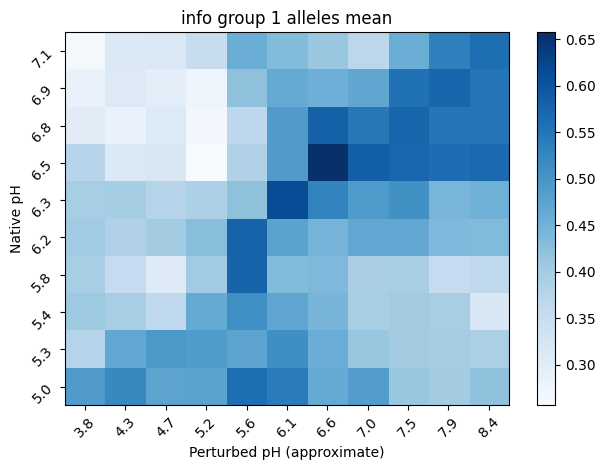

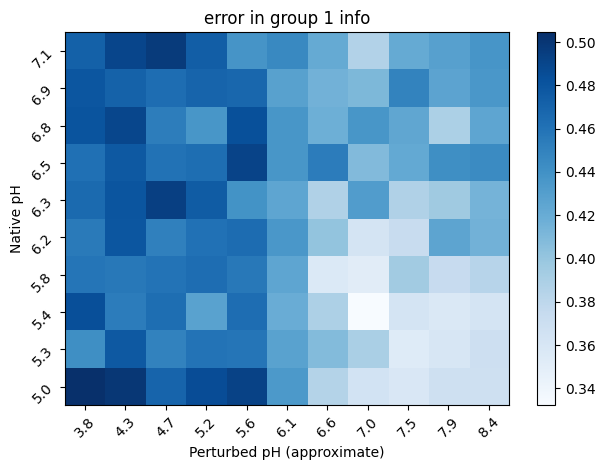

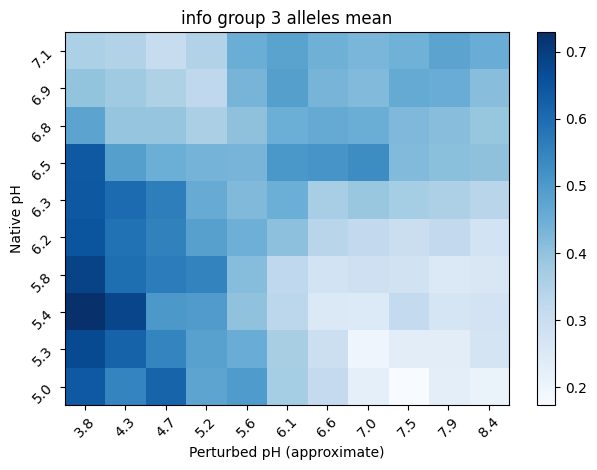

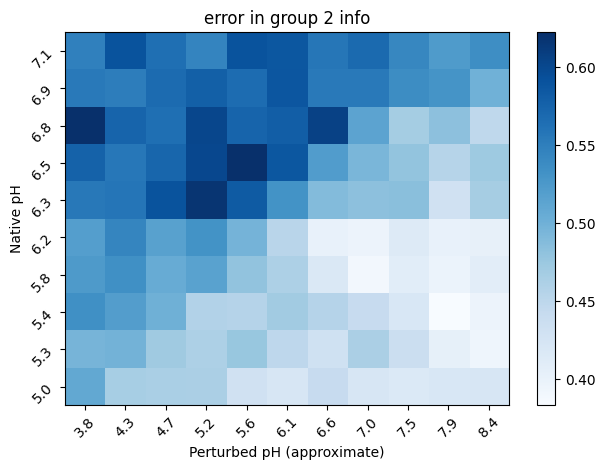

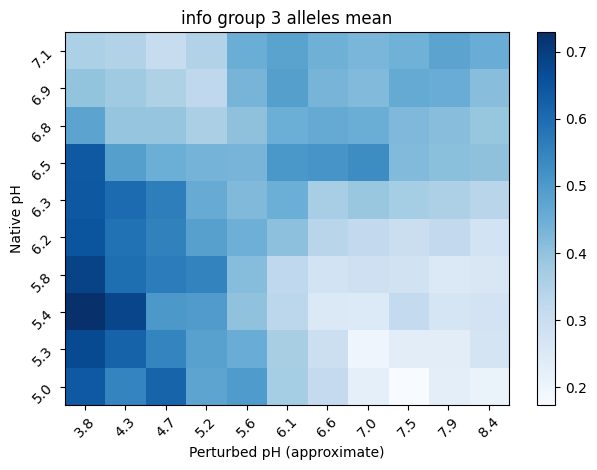

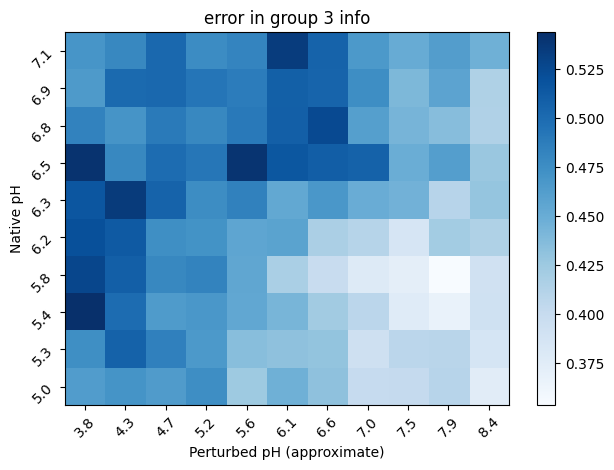

In [48]:
plot(info1, 'info group 1 alleles mean')
plot((info1_high - info1_low)/2, 'error in group 1 info')
plot(info3, 'info group 3 alleles mean')
plot((info2_high - info2_low)/2, 'error in group 2 info')
plot(info3, 'info group 3 alleles mean')
plot((info3_high - info3_low)/2, 'error in group 3 info')

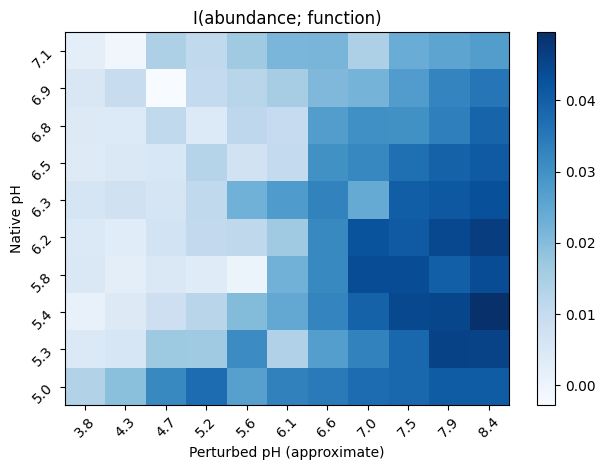

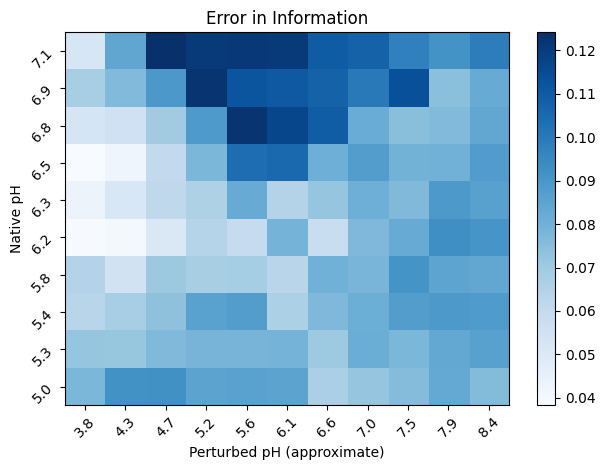

In [28]:

perturbed = np.linspace(3.8,8.4, 11)
pH = np.zeros((10, 11))
for row in pH:
    row += perturbed
    
pH_info, pH_low, pH_high =  information_2D((group1_T0 + group1_T9)/2, data_slope, neighborhood_size = 60, k = 6)

plot(pH_info, 'I(abundance; function)')
plot((pH_high - pH_low)/2, 'Error in Information')



In [6]:

perturbed = np.linspace(3.8,8.4, 11)
pH = np.zeros((10, 11))
for row in pH:
    row += perturbed
    
data = np.zeros((11,10))
for datum in data:
    datum += native
    
nat_pH = data.T
    

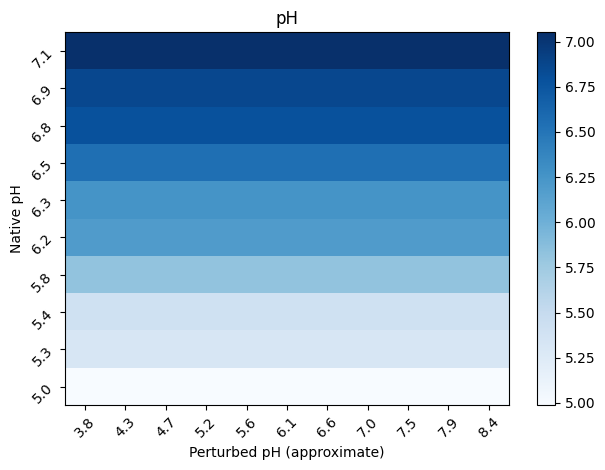

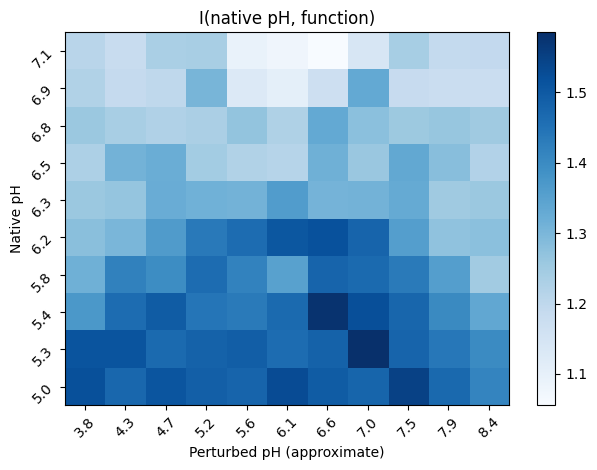

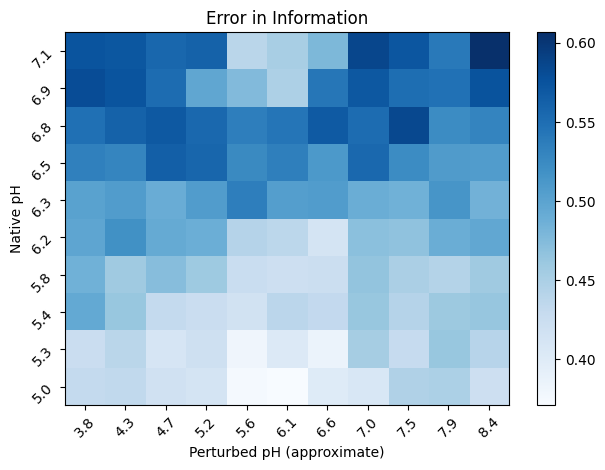

In [8]:
data = np.zeros((11,10))
for datum in data:
    datum += native
    
nat_pH = data.T
    
natpH_info, natpH_low, natpH_high =  information_2D(nat_pH, group3_T9 - group3_T0, neighborhood_size = 60, k = 6)

plot(nat_pH, 'pH')
plot(natpH_info, 'I(native pH, function)')
plot((natpH_high - natpH_low)/2, 'Error in Information')

In [ ]:
#info between native pH and change
natpH_info, natpH_low, natpH_high =  information_2D(nat_pH, group2_T9 - group2_T0, neighborhood_size = 70, k = 6)

plot(nat_pH, 'pH')
plot(natpH_info, 'I(native pH, function)')
plot((natpH_high - natpH_low)/2, 'pH error pH')

In [11]:
perturbed = np.linspace(3.8,8.4, 11)
pH = np.zeros((10, 11))
for row in pH:
    row += perturbed

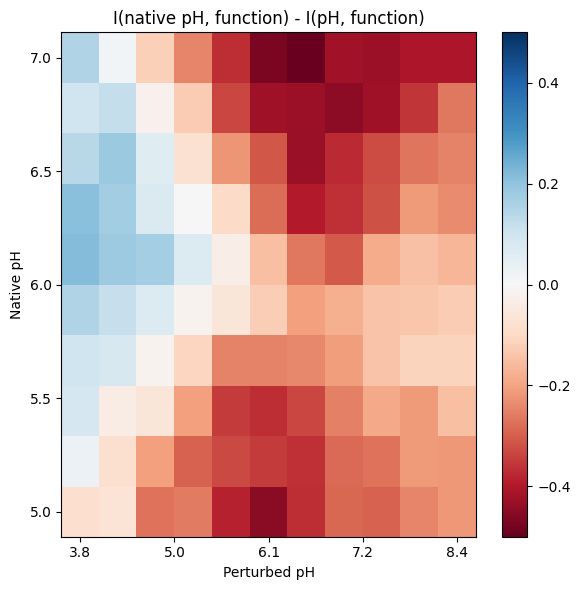

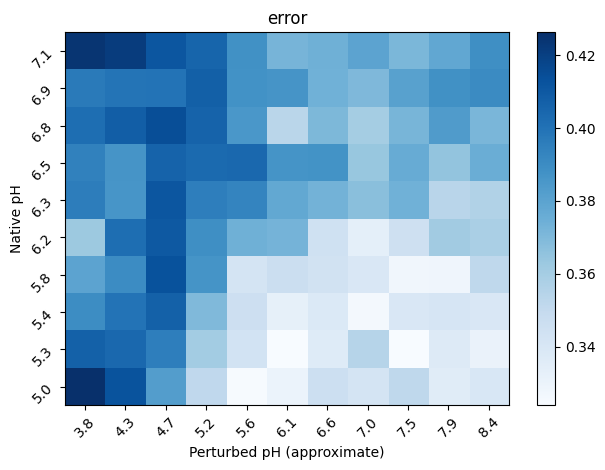

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

x_min, x_max = 3.8, 8.4 
y_min, y_max = 5, 7 
data = natpH_info - pH_info

cax = ax.imshow(data, cmap = 'RdBu', origin='lower', aspect='auto', vmin = -0.5, vmax = 0.5)

# Set custom tick positions and labels
num_ticks = 5  # number of ticks to show
x_ticks = np.linspace(0, data.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, data.shape[0] - 1, num_ticks)
x_labels = np.linspace(x_min, x_max, num_ticks)
y_labels = np.linspace(y_min, y_max, num_ticks)

ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{label:.1f}" for label in x_labels])
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{label:.1f}" for label in y_labels])

# Add colorbar and labels
plt.colorbar(cax, ax=ax)
ax.set_xlabel("Perturbed pH")
ax.set_ylabel("Native pH")
ax.set_title("I(native pH, function) - I(pH, function)")

# Show the plot
plt.tight_layout()
plt.show()

error = ((natpH_high - natpH_low)**2/4 + (pH_high - pH_low)**2/4)**(1/2)
plot(error, 'error')

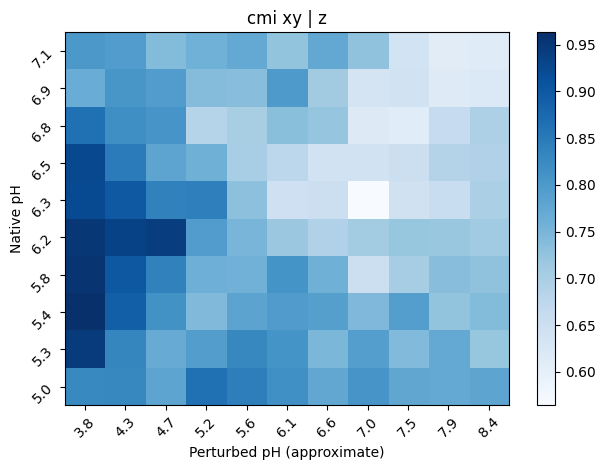

In [8]:


results = pairwise_cmi_analysis(nat_pH, data_final, pH, neighborhood_size=70, k_neighbors = 7)
YZ = results['cmi_xy_z']
plot(YZ, 'cmi xy | z')

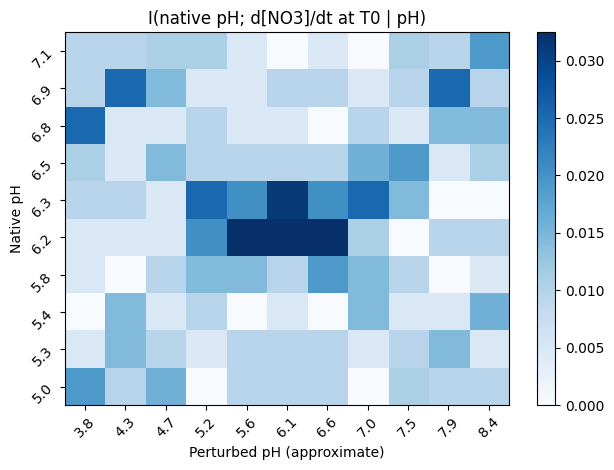

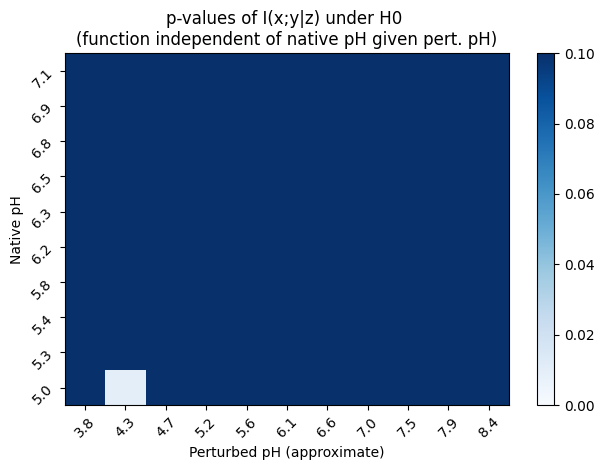

In [97]:

def shuffle_Y_within_X_strata(Y, X, n_bins=10):
    """Shuffle 2D Y within bins of 2D X."""
    # Flatten X and Y for binning
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    
    # Bin X into quantiles (use 2D binning if spatial correlation matters)
    bins = np.quantile(X_flat, np.linspace(0, 1, n_bins + 1))
    X_binned = np.digitize(X_flat, bins[:-1])
    
    # Shuffle Y within each X-bin
    Y_shuffled_flat = Y_flat.copy()
    for bin_id in np.unique(X_binned):
        mask = (X_binned == bin_id)
        Y_shuffled_flat[mask] = np.random.permutation(Y_shuffled_flat[mask])
    
    # Reshape back to 2D
    return Y_shuffled_flat.reshape(Y.shape)

#computing p values by shuffling Y within X strata 
def compute_p_values(X, Y, Z, n_permutations=100):
    """Compute p-values for 2D fields."""
    # Observed CMI (assumes pairwise_cmi_analysis handles 2D inputs)
    observed_result = pairwise_cmi_analysis(X, Y, Z, neighborhood_size=60, k_neighbors = 6)
    observed_cmi = observed_result['cmi_yz_x']
    
    # Initialize p-values
    p_values = np.zeros_like(observed_cmi)
    
    # Permutation test
    for _ in range(n_permutations):
        Y_shuffled = shuffle_Y_within_X_strata(Y, X)
        shuffled_result = pairwise_cmi_analysis(X, Y_shuffled, Z, neighborhood_size=60, k_neighbors = 6)
        p_values += (shuffled_result['cmi_yz_x'] >= observed_cmi)
    
    return (p_values + 1) / (n_permutations + 1)

p_values = compute_p_values(
    X=nat_pH,  
    Y=data_slope,  
    Z=pH,
    n_permutations=100
)

# Plot p-values
plot(pairwise_cmi_analysis(nat_pH, data_slope, pH, neighborhood_size=60, k_neighbors = 6)['cmi_yz_x'], 'I(native pH; d[NO3]/dt at T0 | pH)')
plot(p_values, 'p-values of I(x;y|z) under H0 \n(function independent of native pH given pert. pH)', vmin = 0, vmax = 0.1)
plt.show()

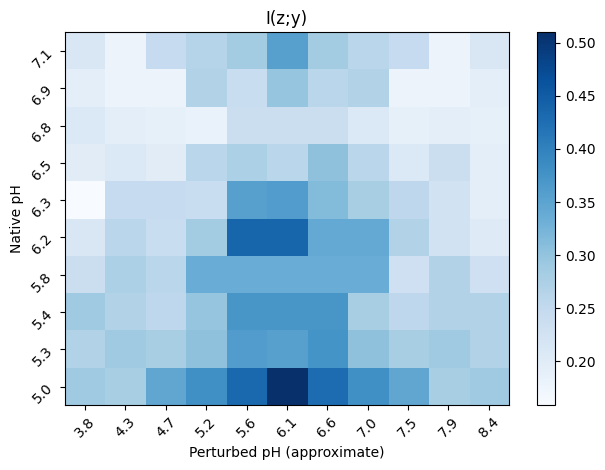

In [98]:
plot(pairwise_cmi_analysis(pH, data_slope, nat_pH, neighborhood_size=50, k_neighbors = 4)['cmi_yz_x'], 'I(z;y)')

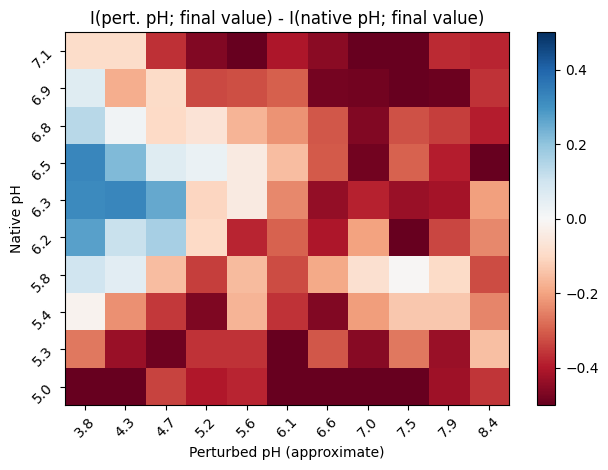

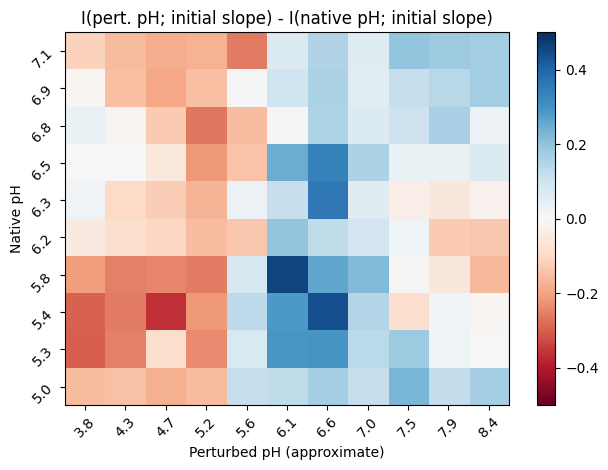

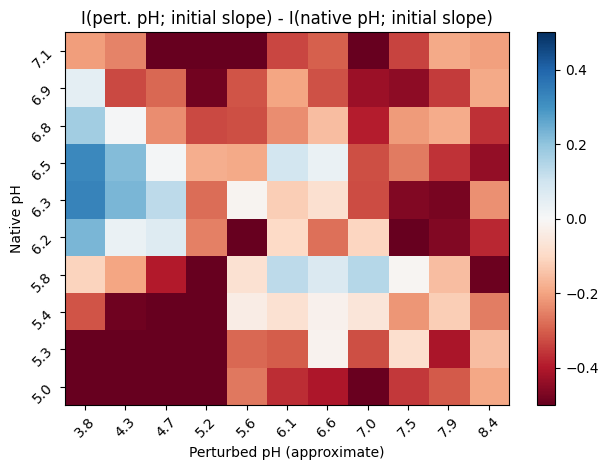

In [14]:
#A = pairwise_cmi_analysis((group1_T0 + group1_T9)/2, data_final, pH)['cmi_xy_z'] - pairwise_cmi_analysis((group1_T0 + group1_T9)/2, data_final, pH)['cmi_yz_x']
#A += pairwise_cmi_analysis((group1_T0 + group1_T9)/2, data_slope, pH)['cmi_xy_z'] - pairwise_cmi_analysis((group1_T0 + group1_T9)/2, data_slope, pH)['cmi_yz_x']
#A = pairwise_cmi_analysis((group2_T0 + group2_T9)/2, data_final, pH)['cmi_xy_z'] - pairwise_cmi_analysis((group2_T0 + group2_T9)/2, data_final, pH)['cmi_yz_x']
#A += pairwise_cmi_analysis((group2_T0 + group2_T9)/2, data_slope, pH)['cmi_xy_z'] - pairwise_cmi_analysis((group2_T0 + group2_T9)/2, data_slope, pH)['cmi_yz_x']
#A = pairwise_cmi_analysis((group3_T0 + group3_T9)/2, data_final, pH)['cmi_xy_z'] - pairwise_cmi_analysis((group3_T0 + group3_T9)/2, data_final, pH)['cmi_yz_x']
#A += pairwise_cmi_analysis((group3_T0 + group3_T9)/2, data_slope, pH)['cmi_xy_z'] - pairwise_cmi_analysis((group3_T0 + group3_T9)/2, data_slope, pH)['cmi_yz_x']
A = pairwise_cmi_analysis(nat_pH, data_final, pH)['mi_xy'] - pairwise_cmi_analysis(pH, data_final, pH)['mi_xy']
B = pairwise_cmi_analysis(nat_pH, data_slope, pH)['mi_xy'] - pairwise_cmi_analysis(pH, data_slope, pH)['mi_xy']
plot(A, 'I(pert. pH; final value) - I(native pH; final value)', cmap = 'RdBu', vmin = -0.5, vmax = 0.5)
plot(B, 'I(pert. pH; initial slope) - I(native pH; initial slope)', cmap = 'RdBu', vmin = -0.5, vmax = 0.5)
plot(A + B, 'I(pert. pH; initial slope) - I(native pH; initial slope)', cmap = 'RdBu', vmin = -0.5, vmax = 0.5)


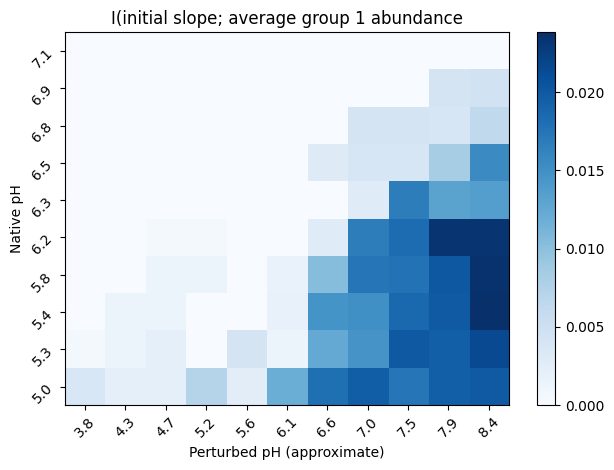

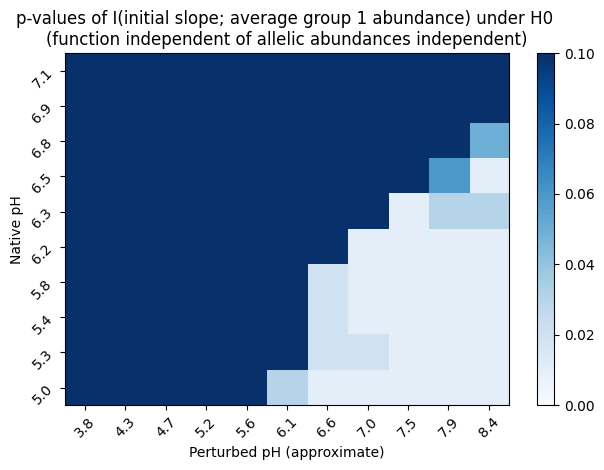

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def shuffle_Y(Y):
    """Shuffle 2D Y values while preserving their positions in the array."""
    # Flatten Y for shuffling
    Y_flat = Y.ravel()
    
    # Shuffle all Y values
    Y_shuffled_flat = np.random.permutation(Y_flat)
    
    # Reshape back to original shape
    return Y_shuffled_flat.reshape(Y.shape)

#computing p values by shuffling Y within X strata 
def compute_p_values(X, Y, Z, n_permutations=100):
    """Compute p-values for 2D fields."""
    # Observed CMI (assumes pairwise_cmi_analysis handles 2D inputs)
    observed_result = pairwise_cmi_analysis(X, Y, Z, neighborhood_size=60, k_neighbors = 6)
    observed_cmi = observed_result['mi_xy']
    
    # Initialize p-values
    p_values = np.zeros_like(observed_cmi)
    
    # Permutation test
    for _ in range(n_permutations):
        Y_shuffled = shuffle_Y(Y)
        shuffled_result = pairwise_cmi_analysis(X, Y_shuffled, Z, neighborhood_size=60, k_neighbors = 6)
        p_values += (shuffled_result['mi_xy'] >= observed_cmi)
    
    return (p_values + 1) / (n_permutations + 1)

p_values = compute_p_values(
    X= data_slope,  
    Y= (group1_T0 + group1_T9)/2, 
    Z= pH, 
    n_permutations=100
)

# Plot p-values
plot(pairwise_cmi_analysis(data_slope, (group1_T0 + group1_T9)/2, pH, neighborhood_size=60, k_neighbors = 6)['mi_xy'], 'I(initial slope; average group 1 abundance', vmin = 0)
plot(p_values, 'p-values of I(initial slope; average group 1 abundance) under H0 \n(function independent of allelic abundances independent)', vmin = 0, vmax = 0.1)
plt.show()

In [39]:
print(get_info((group3_T0 + group3_T9)/2, data_slope))

(0.03007463749634782, 0.16301104067225944, 0.26732673267326734)


In [8]:
print(get_info( (group2_T0 + group2_T9)/2, data_slope, permute = 1000))
print(get_info_control((group2_T0 + group2_T9)/2, data_slope, nat_pH, permute = 1000))


(0.16380993251340625, 0.1836439054917157, 0.01098901098901099)
(0.09956781683710915, 0.18798880762748935, 0.014985014985014986)
